<a href="https://colab.research.google.com/github/karthikpuranik11/FIRE2021/blob/main/Kannada/Bert%2BbiLSTM_Kannada_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1 MB 7.5 MB/s 
     |████████████████████████████████| 3.0 MB 62.0 MB/s 
     |████████████████████████████████| 895 kB 63.9 MB/s 
     |████████████████████████████████| 1.2 MB 48.5 MB/s 


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train1=pd.read_csv('/content/kan_final.csv')
train1['labels']=LabelEncoder().fit_transform(train1['category'])
#train=train.drop(columns='label')
train1

,Unnamed: 0,Unnamed: 0.1,text,category,trans,translate,labels
0,0,0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,The progress of a country does not depend on i...,1
1,1,1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Subscribe to our channel for Daily Tech update...,2
2,2,2,Super sar song,not-Kannada,ಸೂಪರ್ ಸರ್ ಸಾಂಗ್,Superb song\n,3
3,3,3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative,ಟಿಕ್ಚೋಕರ್ಸ್ ಪೆರೆಂಟ್ ಸಿಟ್ಯೂಶನ್... ನ್ನೋಡುವವರು ಯಾ...,Tik Chockers' Parent Status: Who's watching ou...,1
4,4,4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive,ಸೂಪರ್ ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,The song is very peppy.\n,2
...,...,...,...,...,...,...,...
6207,6207,6207,@A.R.W tumbad tanhaji andhadhun aise bahot h...,not-Kannada,@ಏ.ರ್.ಎ ತಂಬದ್ ತಂಜಾಜಿ ಅಂಧಧುನ್ ಐಸ್ಡ್ ಬಹತ್ ಹೈ ಪ್ರ...,"@ arra _ tambad, tanjaji, Andhadhun, aisd baat...",3
6208,6208,6208,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്,not-Kannada,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്,(in Korean)\n,3
6209,6209,6209,Bro...nNeen este Roast madudru...China ne beku...,Negative,ಬ್ರೋ...ನ್ಯೂನ್ ಎಸ್ಟ್ ರೋಸ್ಟ್ ಮಾಡುದ್ರು...ಚೀನಾ ನೇ ...,""""" ""Bro..."" """" """" """" """" """" """" """" ""\n",1
6210,6210,6210,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...,Positive,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...,There is no dearth of talented people in our c...,2


In [35]:
for i in range(len(train1)):
  if train1['category'][i]=='not-Kannada':
    train1['translate'][i]='NaN'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
train=pd.DataFrame(columns=['labels','tweets'])
train['labels']=train1['labels'].append(train1['labels'])
train['tweets']=train1['text'].append(train1['translate'])
train

,labels,tweets
0,1,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...
1,2,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...
2,3,Super sar song
3,1,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...
4,2,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....
...,...,...
6207,3,NaN
6208,3,NaN
6209,1,""""" ""Bro..."" """" """" """" """" """" """" """" ""\n"
6210,2,There is no dearth of talented people in our c...


In [37]:
train=train.dropna()

In [38]:
val=pd.read_csv('/content/kannada_sentiment_full_test_withlabels.tsv', sep="\t")
#val['tweet']=val['text']
#val=val.drop(columns=['Unnamed: 2','text'])
val['labels']=LabelEncoder().fit_transform(val['category'])
val['tweets']=val['text']
val=val.drop(columns=['category','text'])
val

,id,labels,tweets
0,Kan_1,2,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...
1,Kan_2,4,Jai D Boss
2,Kan_3,3,Signature move
3,Kan_4,2,Super song bro
4,Kan_5,2,Wow Super agi helidira sir
...,...,...,...
763,Kan_764,4,Thu thukali trailer
764,Kan_765,1,Siri gannadam galge haakbitallapa Thu yaro ni...
765,Kan_766,2,ನಾವೇನಾದರು ಸ್ವಾಬಿಮಾನಿಯಾಗಿ ಬದುಕನ್ನು ಕಟ್ಟಿಕೊಳ್ಳಲು...
766,Kan_767,4,ದಿಯಾ ನೀವು ಸೋಷಿಯಲ್ ಮೀಡಿಯಾ ಅಲ್ಲಿ ಕಾಣ್ತಿಲ್ಲ.nದಯವಿ...


In [39]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [40]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (12424, 2)
validation set size: (768, 3)


In [41]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([2.16445993, 1.04579125, 0.44009919, 1.35633188, 1.74739803])

In [42]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [43]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [44]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [45]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [46]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [47]:
model = RFClassifier(5)
model = model.to(device)

In [48]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [49]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [50]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [51]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [52]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-uncased.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01 | Epoch Time: 5m 4s
Train Loss 1.2782387431605615 accuracy 0.5476497102382485
Val Loss 1.0866719807187717 accuracy 0.5729166666666666

Epoch: 02 | Epoch Time: 5m 4s
Train Loss 0.9157137138371603 accuracy 0.6567933032839665
Val Loss 1.000073234240214 accuracy 0.6145833333333333

Epoch: 03 | Epoch Time: 5m 3s
Train Loss 0.7511251074642632 accuracy 0.733258209916291
Val Loss 1.0102978746096294 accuracy 0.6328125

Epoch: 04 | Epoch Time: 5m 3s
Train Loss 0.6313166498831427 accuracy 0.7825981970379909
Val Loss 1.0857647508382797 accuracy 0.6276041666666666

Epoch: 05 | Epoch Time: 5m 3s
Train Loss 0.5536860103089276 accuracy 0.8135061171925305
Val Loss 1.1043468788266182 accuracy 0.63671875



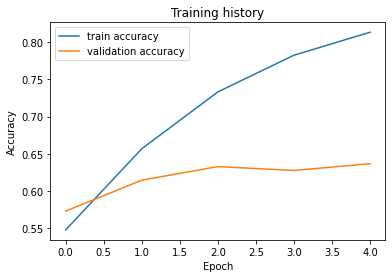

In [54]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [55]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.63671875

In [56]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [57]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [58]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred,zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.2424    0.1231    0.1633        65
           1     0.6023    0.6752    0.6366       157
           2     0.7046    0.7781    0.7395       374
           3     0.6705    0.5364    0.5960       110
           4     0.4310    0.4032    0.4167        62

    accuracy                         0.6367       768
   macro avg     0.5302    0.5032    0.5104       768
weighted avg     0.6176    0.6367    0.6231       768

